In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/GeneralFunctions")

CPU times: user 163 µs, sys: 134 µs, total: 297 µs
Wall time: 234 µs


# Import Agulhas data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 164 ms, sys: 45.5 ms, total: 210 ms
Wall time: 218 ms


# Data/Parameters for Dynamical System

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 18

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

CPU times: user 111 µs, sys: 15 µs, total: 126 µs
Wall time: 124 µs


<a id='Spatio-Temporal-Domain-of-Dynamical-System'></a>
# Spatio-temporal domain of dynamical system

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundaries (in degrees)
xmin = 2
xmax = 7
ymin = -38
ymax = -33

# spacing of meshgrid (in degrees)
dx = 0.05
dy = 0.05

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# Summarize spatio-temporal domain of dynamical system
params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

CPU times: user 413 ms, sys: 99.3 ms, total: 513 ms
Wall time: 530 ms


## Velocity interpolation

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 96.9 ms, sys: 9.53 ms, total: 106 ms
Wall time: 107 ms


# Rate of strain tensor $ S(\mathbf{x},t) $

In [6]:
%%time
from tqdm.notebook import tqdm

# Define Rate of Strain over meshgrid (Ny, Nx, 2, 2)
S = np.zeros((X_domain.shape[0], X_domain.shape[1], 2, 2))*np.nan

# Iterate over meshgrid
for i in tqdm(range(X_domain.shape[0])):
    
    for j in range(X_domain.shape[1]):
        
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        # Compute rate of strain
        S[i, j,:,:] = DS._spin_tensor(x, t_OECS)

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: user 4.66 s, sys: 1.02 s, total: 5.68 s
Wall time: 4.87 s


# Compute rate of attraction/repulsion over meshgrid

In [7]:
from ipynb.fs.defs.eigen import eigen_S

s = S[:,:,0,0].copy()*np.nan

for i in range(S.shape[0]):
    
    for j in range(S.shape[1]):
        
        s[i,j] = np.abs(eigen_S(S[i,j,:,:])[0])

# Find objective Saddle-points

In [8]:
from ipynb.fs.defs.loc_max import _loc_max

# minimum distance between objective saddles (=local maxima in the s2-field)
min_distance = .1

# indices, positions and value (of s2-field) of the objective saddles
loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(min_distance, X_domain, Y_domain, s)

  0%|          | 0/29 [00:00<?, ?it/s]

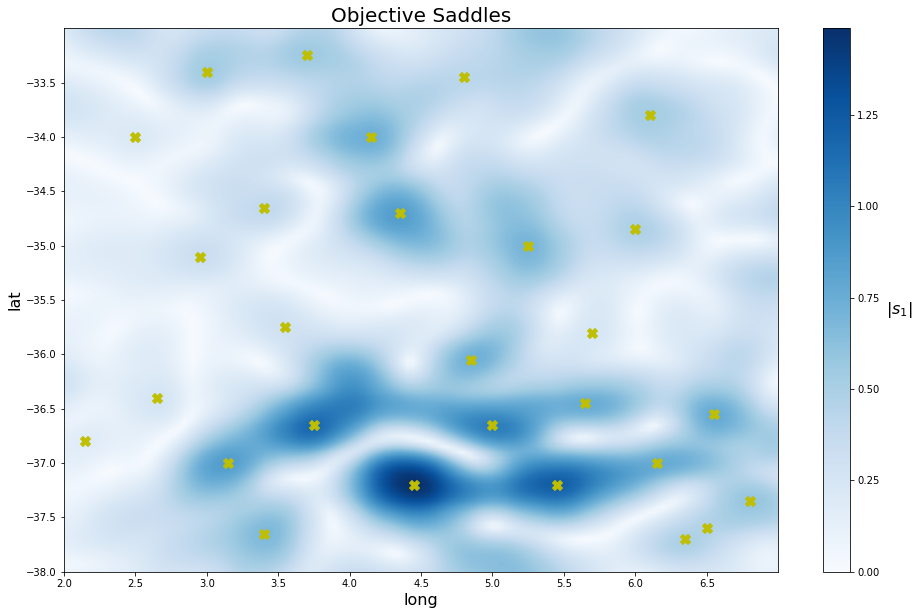

In [9]:
###################################### PLOT OBJECTIVE SADDLES ######################################
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 10))
ax = plt.axes()

cax = ax.contourf(X_domain, Y_domain, s, levels = 400, cmap = "Blues")

ax.scatter(loc_max_x, loc_max_y, c = 'y', marker = "X", s = 100)
    
ax.set_xlabel('long', fontsize = 16)
ax.set_ylabel('lat', fontsize = 16)

ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), .5))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), .5))

ax.set_title('Objective Saddles', fontsize = 20)

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.25))
cbar.set_label(r'$ |s_1| $', rotation = 0, labelpad = 20, fontsize = 16)

plt.show()

## Shrinklines (Repelling OECS)

Repelling LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0(s) = \xi_1(\mathbf{x}_0;t),
\label{eq: shrinklines}
\end{equation}

with $ \xi_1 $ denoting the eigenvector associated to the weakest eigenvalue $ s_1 $ of $ S(\mathbf{x},t) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ s_1 = s_2 $).
The most repelling shrinklines mark initial positions of repelling LCSs. Repelling LCSs can therefore be located as trajectories of eq. \ref{eq: shrinklines} that have locally the largest averaged $ s_2(\mathbf{x},t) $ among all neighbouring shrinklines.

In [10]:
from ipynb.fs.defs.shrinklines import _shrinklines

# step-size used for integration with respect to parameter 's'
step_size = 0.001

# threshold distance to locate local maxima in the 's_2' field of 'S'
max_distance = 0.1

# maximum length of shrinkline
max_length = 3

# Requires that the TRAP is repelling at least dAttr
dAttr = .01

shrinklines = _shrinklines(X_domain, Y_domain, S, max_distance, max_length, step_size, dAttr)

  0%|          | 0/29 [00:00<?, ?it/s]

## Stretchlines (Attracting OECS)

Attracting LCS can be sought among trajectories of the differential equation:

\begin{equation}
\mathbf{x}'_0 = \xi_2(\mathbf{x}_0;t),
\label{eq: stretchlines}
\end{equation}

with $ \xi_2 $ denoting the eigenvector associated to the strongest eigenvalue $ s_2 $ of $ S(\mathbf{x},t) $. The non-orientable vector field is well defiend away from tensorline singularites (points where $ s_1 = s_2 $).
The most attracting stretchlines mark initial positions of attracting LCSs. Attracting OECSs can therefore be located as trajectories of eq. \ref{eq: stretchlines} that have locally the smallest averaged $ s_1(\mathbf{x},t) $ among all neighbouring stretchlines.

In [11]:
from ipynb.fs.defs.stretchlines import _stretchlines

# step-size used for integration with respect to parameter 's'
step_size = 0.001

# threshold distance to locate local minima in the 's_1' field of 'S'
max_distance = 0.1

# maximum length of stretchline
max_length = 3

# Requires that the TRAP is attracting at least dRep
dRep = 0.01

stretchlines = _stretchlines(X_domain, Y_domain, S, max_distance, max_length, step_size, dRep)

  0%|          | 0/29 [00:00<?, ?it/s]

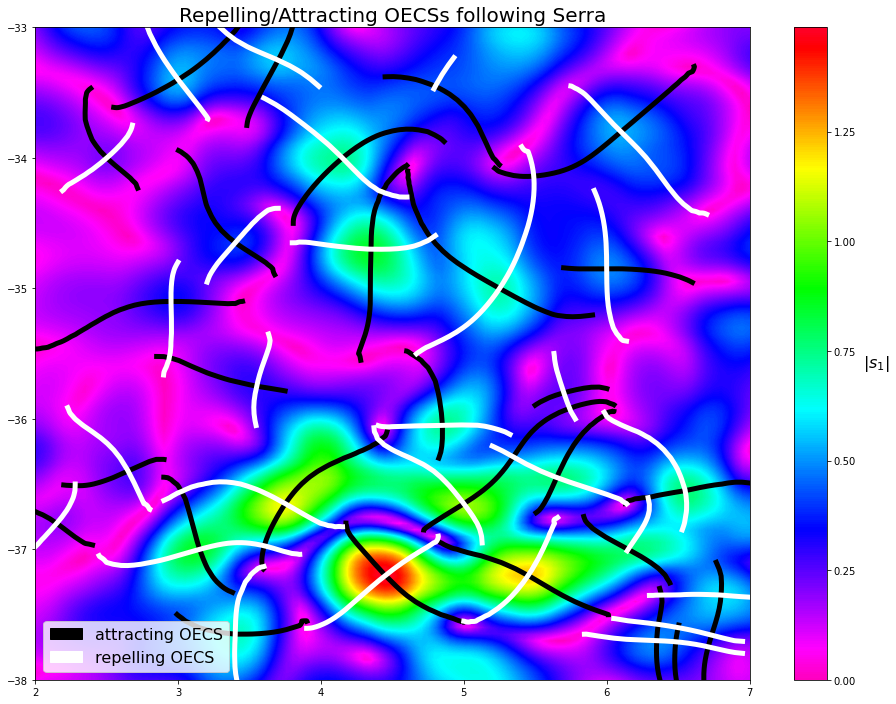

In [13]:
################################ PLOT HYPERBOLIC OECS ################################

import matplotlib.pyplot as plt

# generate figure and axis object
fig = plt.figure(figsize = (16, 12))
ax = plt.axes()

# Plot s2-field
cax = ax.contourf(X_domain, Y_domain, s, levels = 600, cmap = "gist_rainbow_r")

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.25))
cbar.set_label(r'$ |s_1| $', rotation = 0, labelpad = 20, fontsize = 16)

# Plot attracting OECS  
for i in range(len(stretchlines[0])):
    ax_attracting = ax.plot(stretchlines[0][i], stretchlines[1][i], c = 'k', linewidth = 5)

# Plot repelling OECS
for j in range(len(shrinklines[0])):
    ax_repelling = ax.plot(shrinklines[0][j], shrinklines[1][j], c = "w", linewidth = 5)

# set limits
ax.set_xlim(np.min(X_domain), np.max(X_domain))
ax.set_ylim(np.min(Y_domain), np.max(Y_domain))

# plot e2 vector-field
#ax.quiver(X_domain[::4,::4], Y_domain[::4,::4], v2[::4,::4,0], v2[::4,::4,1])

# Set title
ax.set_title('Repelling/Attracting OECSs following Serra', fontsize = 20)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='k', label='attracting OECS')
repelling = mpatches.Patch(color='w', label='repelling OECS')
plt.legend(handles=[attracting, repelling], fontsize = 16,  loc = "lower left")
 
# Show plot
plt.show()